In [ ]:
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# Chuẩn bị dữ liệu

In [ ]:
# Chuẩn bị dữ liệu CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:06<00:00, 26272788.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


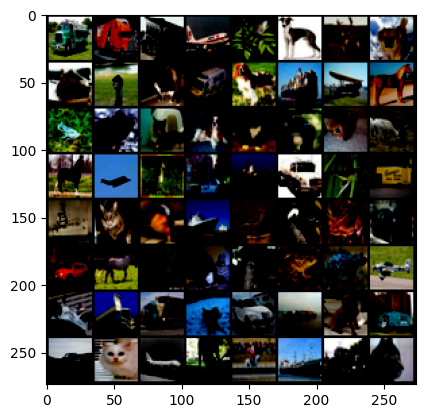

truck truck truck plane bird  dog   deer  dog   frog  bird  cat   car   dog   ship  plane horse frog  frog  cat   dog   cat   bird  cat   deer  horse plane bird  car   ship  truck bird  truck ship  cat   bird  ship  bird  bird  frog  car   car   horse deer  cat   bird  frog  frog  plane plane truck truck dog   car   ship  dog   truck car   cat   plane deer  horse ship  truck cat  


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Huấn luyện với mô hình CNN

In [ ]:
class CNNetwork(nn.Module):
    def __init__(self, drop_out):
        super(CNNetwork, self).__init__()
        self.drop_out = drop_out
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        if self.drop_out == True:
          out = self.dropout1(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        if self.drop_out == True:
          out = self.dropout2(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
# Huấn luyện mô hình
def train(model,device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  loss_tracking = []
  acc_tracking = []
  total_time = 0.0
  epochs = 20
  for epoch in range(epochs):
      running_loss = 0.0
      start = time.time()
      for i, data in enumerate(trainloader, 0):
          # Lấy dữ liệu vào và làm sạch gradient
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Chạy mô hình và tính loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          # Backpropagation và cập nhật trọng số
          loss.backward()
          optimizer.step()

          # In thông tin quá trình huấn luyện
          running_loss += loss.item()
      end = time.time()
      total_time += (end - start)
      acc = test(model, device)
      acc_tracking.append(acc)
      print('Epoch [{}/{}], Time: {:.2f}s,  Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, epochs, end - start, (running_loss/len(trainloader)), acc))
      loss_tracking.append((running_loss/len(trainloader)))
      running_loss = 0.0
  plt.subplot(1, 3, 1)
  plt.plot(loss_tracking)
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.subplot(1, 3, 3)
  plt.plot(acc_tracking)
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.show()
  print("Tổng thời gian huấn luyện: {:.2f}, thời gian trung bình mỗi epoch: {:.2f}".format(total_time, total_time/epochs))
  print('Huấn luyện xong')

def test(model,device):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs_test, labels_test = data
          inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
          outputs = model(inputs_test)
          _, predicted = torch.max(outputs.data, 1)
          total += labels_test.size(0)
          correct += (predicted == labels_test).sum().item()
  return 100 * correct / total

## Huấn luyện mô hình CNN cơ bản không sử dụng Drop_out

In [ ]:
model = CNNetwork(drop_out = False).to(device)
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                   [-1, 10]          20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 0.10
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


Epoch [1/20], Time: 14.91s,  Loss: 1.4844, Accuracy: 59.19%
Epoch [2/20], Time: 14.38s,  Loss: 1.0877, Accuracy: 61.48%
Epoch [3/20], Time: 15.01s,  Loss: 0.9609, Accuracy: 67.49%
Epoch [4/20], Time: 20.37s,  Loss: 0.8923, Accuracy: 67.82%
Epoch [5/20], Time: 14.41s,  Loss: 0.8333, Accuracy: 68.69%
Epoch [6/20], Time: 14.61s,  Loss: 0.8006, Accuracy: 68.33%
Epoch [7/20], Time: 14.62s,  Loss: 0.7716, Accuracy: 69.18%
Epoch [8/20], Time: 14.56s,  Loss: 0.7383, Accuracy: 68.88%
Epoch [9/20], Time: 14.70s,  Loss: 0.7188, Accuracy: 69.60%
Epoch [10/20], Time: 15.97s,  Loss: 0.7027, Accuracy: 69.08%
Epoch [11/20], Time: 14.99s,  Loss: 0.6879, Accuracy: 69.04%
Epoch [12/20], Time: 14.76s,  Loss: 0.6717, Accuracy: 69.00%
Epoch [13/20], Time: 14.49s,  Loss: 0.6584, Accuracy: 69.50%
Epoch [14/20], Time: 14.57s,  Loss: 0.6513, Accuracy: 69.05%
Epoch [15/20], Time: 16.74s,  Loss: 0.6379, Accuracy: 69.27%
Epoch [16/20], Time: 14.56s,  Loss: 0.6325, Accuracy: 67.08%
Epoch [17/20], Time: 14.44s,  Los

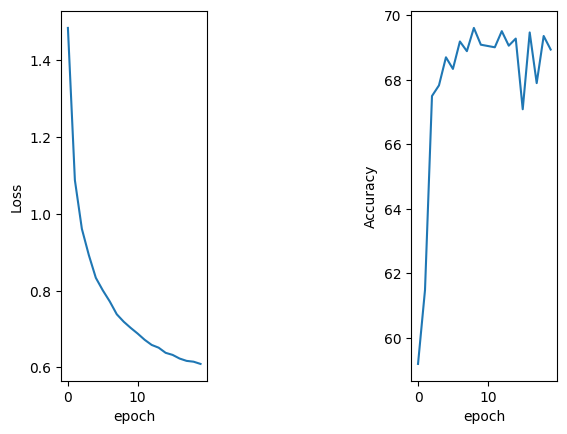

Tổng thời gian huấn luyện: 302.92, thời gian trung bình mỗi epoch: 15.15
Huấn luyện xong


In [ ]:
train(model, device)

##Huấn luyện mô hình sử dụng Drop_out

In [ ]:
model = CNNetwork(drop_out = True).to(device)
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
           Dropout-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
              ReLU-6           [-1, 32, 16, 16]               0
           Dropout-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 10]          20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.61
Params size (MB): 0.10
Estimated Total Size (MB): 0.72
---------------------------------------------

Epoch [1/20], Time: 14.89s,  Loss: 1.4677, Accuracy: 55.43%
Epoch [2/20], Time: 14.81s,  Loss: 1.1673, Accuracy: 60.87%
Epoch [3/20], Time: 14.67s,  Loss: 1.0656, Accuracy: 62.20%
Epoch [4/20], Time: 14.67s,  Loss: 1.0116, Accuracy: 64.03%
Epoch [5/20], Time: 15.55s,  Loss: 0.9696, Accuracy: 62.29%
Epoch [6/20], Time: 14.66s,  Loss: 0.9514, Accuracy: 63.98%
Epoch [7/20], Time: 14.67s,  Loss: 0.9323, Accuracy: 63.94%
Epoch [8/20], Time: 14.82s,  Loss: 0.9163, Accuracy: 65.83%
Epoch [9/20], Time: 14.66s,  Loss: 0.9077, Accuracy: 66.52%
Epoch [10/20], Time: 16.16s,  Loss: 0.8987, Accuracy: 66.29%
Epoch [11/20], Time: 14.81s,  Loss: 0.8928, Accuracy: 66.48%
Epoch [12/20], Time: 14.65s,  Loss: 0.8815, Accuracy: 65.43%
Epoch [13/20], Time: 14.73s,  Loss: 0.8838, Accuracy: 66.93%
Epoch [14/20], Time: 14.77s,  Loss: 0.8754, Accuracy: 66.52%
Epoch [15/20], Time: 15.16s,  Loss: 0.8707, Accuracy: 63.00%
Epoch [16/20], Time: 14.76s,  Loss: 0.8671, Accuracy: 66.40%
Epoch [17/20], Time: 14.87s,  Los

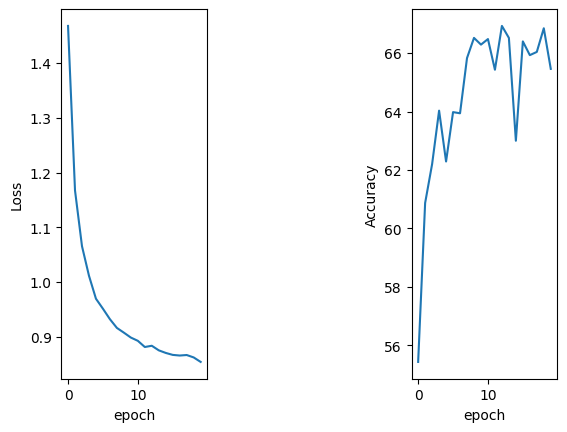

Tổng thời gian huấn luyện: 297.91, thời gian trung bình mỗi epoch: 14.90
Huấn luyện xong


In [ ]:
train(model, device)

# Huấn luyện với mô hình Fully Connected

In [ ]:
class FCNet(nn.Module):
    def __init__(self, drop_out):
        super(FCNet, self).__init__()
        self.drop_out = drop_out
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(p=0.25)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        if self.drop_out == True:
          x = self.dropout1(x)
        x= self.relu(self.fc1(x))
        if self.drop_out == True:
          x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        if self.drop_out == True:
          x = self.dropout3(x)
        x= self.relu(self.fc3(x))

        x = self.fc4(x)
        return x

In [ ]:
model2 = FCNet(drop_out = False).to(device)
summary(model2.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.63
Estimated Total Size (MB): 6.66
----------------------------------------------------------------


Epoch [1/20], Time: 14.51s,  Loss: 1.7762, Accuracy: 45.65%
Epoch [2/20], Time: 14.98s,  Loss: 1.4711, Accuracy: 49.04%
Epoch [3/20], Time: 14.23s,  Loss: 1.3410, Accuracy: 51.85%
Epoch [4/20], Time: 14.62s,  Loss: 1.2485, Accuracy: 52.48%
Epoch [5/20], Time: 14.50s,  Loss: 1.1705, Accuracy: 52.90%
Epoch [6/20], Time: 15.34s,  Loss: 1.1042, Accuracy: 54.14%
Epoch [7/20], Time: 14.43s,  Loss: 1.0278, Accuracy: 54.87%
Epoch [8/20], Time: 14.43s,  Loss: 0.9672, Accuracy: 54.47%
Epoch [9/20], Time: 14.37s,  Loss: 0.9076, Accuracy: 54.95%
Epoch [10/20], Time: 15.49s,  Loss: 0.8446, Accuracy: 54.16%
Epoch [11/20], Time: 14.65s,  Loss: 0.7853, Accuracy: 54.42%
Epoch [12/20], Time: 14.75s,  Loss: 0.7317, Accuracy: 53.75%
Epoch [13/20], Time: 14.56s,  Loss: 0.6768, Accuracy: 53.73%
Epoch [14/20], Time: 14.60s,  Loss: 0.6305, Accuracy: 54.58%
Epoch [15/20], Time: 15.14s,  Loss: 0.5755, Accuracy: 52.56%
Epoch [16/20], Time: 14.67s,  Loss: 0.5311, Accuracy: 52.99%
Epoch [17/20], Time: 14.48s,  Los

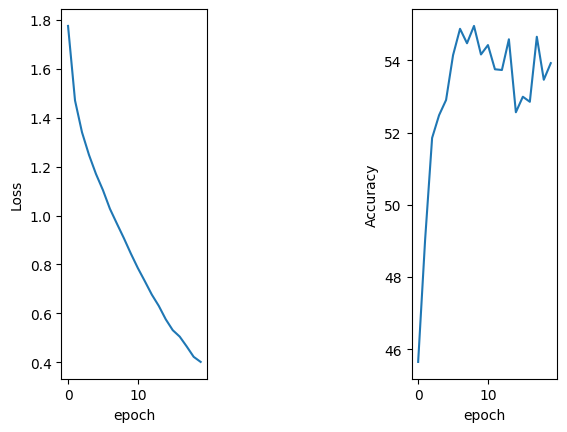

Tổng thời gian huấn luyện: 294.06, thời gian trung bình mỗi epoch: 14.70
Huấn luyện xong


In [ ]:
train(model2, device)

In [ ]:
model2 = FCNet(drop_out = True).to(device)
summary(model2.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 6.63
Estimat

Epoch [1/20], Time: 17.20s,  Loss: 1.8874, Accuracy: 37.99%
Epoch [2/20], Time: 14.92s,  Loss: 1.6832, Accuracy: 42.49%
Epoch [3/20], Time: 15.02s,  Loss: 1.6059, Accuracy: 43.69%
Epoch [4/20], Time: 14.98s,  Loss: 1.5612, Accuracy: 45.11%
Epoch [5/20], Time: 17.58s,  Loss: 1.5293, Accuracy: 44.46%
Epoch [6/20], Time: 19.21s,  Loss: 1.4989, Accuracy: 46.32%
Epoch [7/20], Time: 15.80s,  Loss: 1.4805, Accuracy: 45.49%
Epoch [8/20], Time: 15.07s,  Loss: 1.4600, Accuracy: 46.40%
Epoch [9/20], Time: 15.08s,  Loss: 1.4393, Accuracy: 46.97%
Epoch [10/20], Time: 15.15s,  Loss: 1.4284, Accuracy: 46.51%
Epoch [11/20], Time: 16.17s,  Loss: 1.4176, Accuracy: 47.59%
Epoch [12/20], Time: 15.47s,  Loss: 1.4038, Accuracy: 47.79%
Epoch [13/20], Time: 15.87s,  Loss: 1.3883, Accuracy: 47.62%
Epoch [14/20], Time: 14.76s,  Loss: 1.3802, Accuracy: 48.13%
Epoch [15/20], Time: 15.11s,  Loss: 1.3713, Accuracy: 48.52%
Epoch [16/20], Time: 15.35s,  Loss: 1.3652, Accuracy: 48.09%
Epoch [17/20], Time: 15.37s,  Los

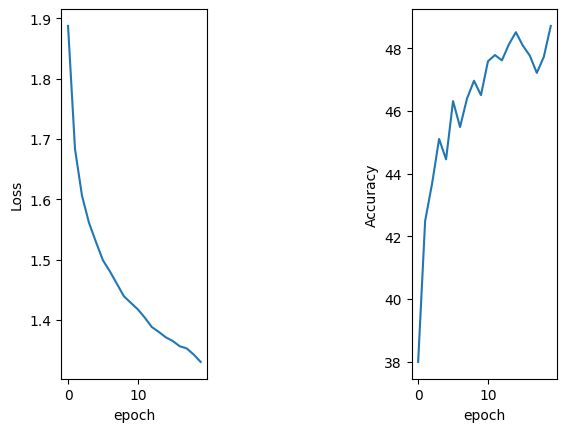

Tổng thời gian huấn luyện: 316.50, thời gian trung bình mỗi epoch: 15.83
Huấn luyện xong


In [ ]:
train(model2, device)

# Huấn luyện với mô hình Resnet-18

In [ ]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
model3 = resnet18().to(device)
summary(model3.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

Epoch [1/20], Time: 43.34s,  Loss: 1.2854, Accuracy: 66.01%
Epoch [2/20], Time: 42.50s,  Loss: 0.7480, Accuracy: 75.40%
Epoch [3/20], Time: 43.16s,  Loss: 0.5330, Accuracy: 77.92%
Epoch [4/20], Time: 42.96s,  Loss: 0.3975, Accuracy: 81.40%
Epoch [5/20], Time: 42.89s,  Loss: 0.2802, Accuracy: 81.00%
Epoch [6/20], Time: 43.22s,  Loss: 0.1991, Accuracy: 80.97%
Epoch [7/20], Time: 42.87s,  Loss: 0.1394, Accuracy: 81.43%
Epoch [8/20], Time: 43.35s,  Loss: 0.1022, Accuracy: 81.35%
Epoch [9/20], Time: 43.09s,  Loss: 0.0751, Accuracy: 80.56%
Epoch [10/20], Time: 43.25s,  Loss: 0.0526, Accuracy: 82.59%
Epoch [11/20], Time: 46.42s,  Loss: 0.0478, Accuracy: 82.52%
Epoch [12/20], Time: 43.20s,  Loss: 0.0403, Accuracy: 82.24%
Epoch [13/20], Time: 43.03s,  Loss: 0.0250, Accuracy: 82.37%
Epoch [14/20], Time: 43.09s,  Loss: 0.0263, Accuracy: 82.95%
Epoch [15/20], Time: 43.08s,  Loss: 0.0174, Accuracy: 83.18%
Epoch [16/20], Time: 43.01s,  Loss: 0.0090, Accuracy: 83.70%
Epoch [17/20], Time: 43.17s,  Los

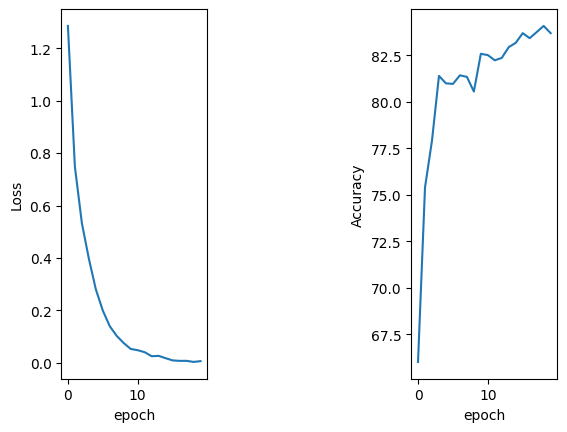

Tổng thời gian huấn luyện: 864.33, thời gian trung bình mỗi epoch: 43.22
Huấn luyện xong


In [ ]:
train(model3, device)

# Huấn luyện với mô hình Resnet-50

In [ ]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

In [ ]:
model4 = resnet50().to(device)
summary(model4.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
       BottleNeck-14          [-1, 256,

Epoch [1/20], Time: 161.87s,  Loss: 1.7587, Accuracy: 49.63%
Epoch [2/20], Time: 162.19s,  Loss: 1.1475, Accuracy: 66.80%
Epoch [3/20], Time: 162.10s,  Loss: 0.8088, Accuracy: 74.55%
Epoch [4/20], Time: 161.80s,  Loss: 0.5967, Accuracy: 77.88%
Epoch [5/20], Time: 162.18s,  Loss: 0.4542, Accuracy: 79.16%
Epoch [6/20], Time: 162.15s,  Loss: 0.3447, Accuracy: 80.16%
Epoch [7/20], Time: 161.99s,  Loss: 0.2542, Accuracy: 79.86%
Epoch [8/20], Time: 161.98s,  Loss: 0.2102, Accuracy: 80.03%
Epoch [9/20], Time: 162.36s,  Loss: 0.1516, Accuracy: 81.12%
Epoch [10/20], Time: 162.24s,  Loss: 0.1179, Accuracy: 81.09%
Epoch [11/20], Time: 161.89s,  Loss: 0.1099, Accuracy: 80.47%
Epoch [12/20], Time: 161.89s,  Loss: 0.0753, Accuracy: 80.18%
Epoch [13/20], Time: 161.87s,  Loss: 0.1293, Accuracy: 81.22%
Epoch [14/20], Time: 162.11s,  Loss: 0.0592, Accuracy: 81.49%
Epoch [15/20], Time: 162.28s,  Loss: 0.0480, Accuracy: 81.01%
Epoch [16/20], Time: 162.27s,  Loss: 0.0437, Accuracy: 81.50%
Epoch [17/20], Ti

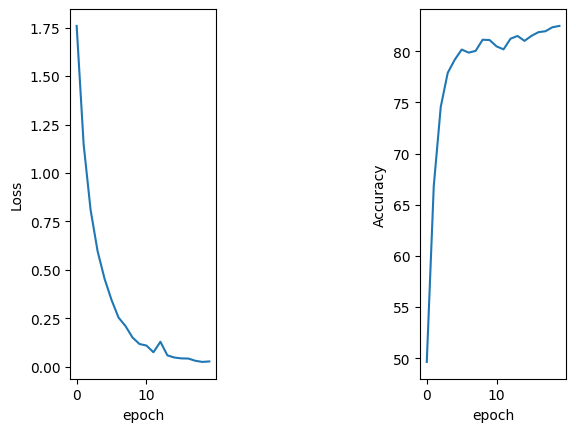

Tổng thời gian huấn luyện: 3240.71, thời gian trung bình mỗi epoch: 162.04
Huấn luyện xong


In [ ]:
train(model4, device)